# Evaluate

This notebook evaluates the quality of the online alignments in a given experiment directory.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pandas as pd
import pickle
import re
import import_ipynb
import system_utils
import eval_tools

## Calculate Alignment Errors

First we calculate the alignment errors of a given system on all evaluated measures.

In [4]:
exp_dir = 'experiments/mixtureDTW' # change
scenarios_dir = 'scenarios'
eval_dir = 'eval/' + os.path.basename(exp_dir)
eval_tools.calcAlignErrors_batch(exp_dir, scenarios_dir, eval_dir)

## Plot Error vs Tolerance

We can visualize the results by plotting the error rate across a range of error tolerances.

In [5]:
def plotErrorVsTolerance(eval_dirs, maxTol, savefile = None, style='bar', bar_tols=[100, 200, 500, 1000, 2000]):
    '''
    Plots the error rate across a range of error tolerances.
    
    Inputs
    eval_dir: the eval directories to plot
    maxTol: maximum error tolerance to consider (in milliseconds)
    savefile: if specified, will save the figure to the given filepath
    style: 'bar' or 'line'
    tols: list of error tolerances to plot if using 'bar'
    '''
    
    errRates_list = []
    for i, eval_dir in enumerate(eval_dirs):
    
        # load
        with open(f'{eval_dir}/errs.pkl', 'rb') as f:
            d = pickle.load(f)

        # flattened list
        errs = []
        for scenario_id in d:
            errs = np.append(errs, d[scenario_id][0])

        # calculate error rates
        errRates = np.zeros(maxTol+1)
        tols = np.arange(maxTol+1)
        for j in tols:
            errRates[j] = np.mean(np.abs(errs) > j/1000)
        errRates_list.append(errRates)
        
        if style == 'line':
            plt.plot(tols, errRates * 100.0)
        elif style == 'bar':
            bar_width = 0.1
            errs = [errRates[tol] * 100.0 for tol in bar_tols]
            pos = np.arange(len(errs)) + i * bar_width
            plt.bar(pos, errs, width=bar_width, label=os.path.basename(eval_dir))
            plt.xticks([r + bar_width*len(eval_dirs)/2 for r in range(len(bar_tols))], map(str, bar_tols))
        
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Error Tolerance (ms)')
    plt.legend([os.path.basename(eval_dir) for eval_dir in eval_dirs])
    plt.grid(linestyle='--')
    if savefile:
        plt.savefig(savefile)

    return errRates_list, tols

Plot the error rate vs error tolerance curve for one system of interest:

41.32387706855792

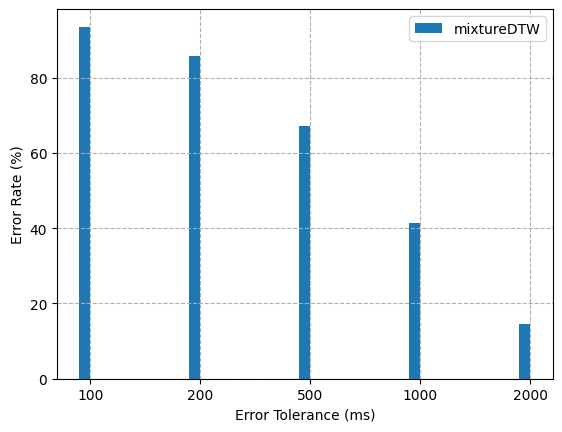

In [6]:
maxTol = 5000 # in milliseconds
eval_dir = 'eval/mixtureDTW'
errRates_list, tols = plotErrorVsTolerance([eval_dir], maxTol, savefile=False)
errRates_list[0][1000]*100.0

Overlay multiple error curves for comparison:

[5.487804878048781,
 10.067750677506774,
 19.97289972899729,
 5.569105691056911,
 11.27371273712737,
 6.720867208672086]

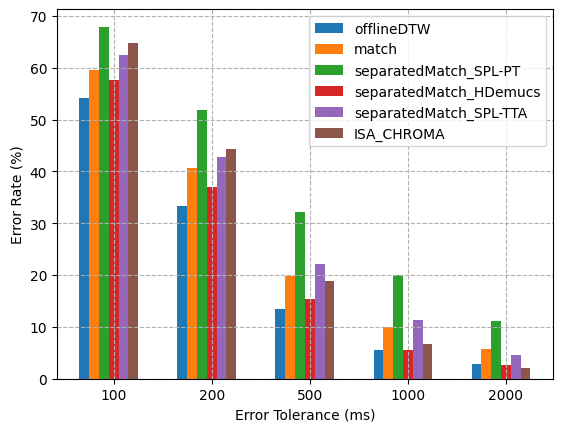

In [7]:
systems_to_compare = ['offlineDTW', 'match', 'separatedMatch_SPL-PT', 'separatedMatch_HDemucs', 'separatedMatch_SPL-TTA', 'ISA_CHROMA']
eval_dirs = [f'eval/{s}' for s in systems_to_compare]
errRates_list, tols = plotErrorVsTolerance(eval_dirs, maxTol, savefile=False)
[errRates_list[i][1000]*100.0 for i in range(len(eval_dirs))]

## Separate error curves by condition

Visualize the same error curve for a single system, but separated by different conditions.  For example, one can visualize the performance across:
- TSM factor
- full mix recording
- concerto
- composer
- chunk within a movement

In [7]:
def plotErrorVsTolerance_separated(eval_dir, mapping, maxTol, savefile = None):
    '''
    Plots error rate across a range of error tolerances.  Data is separated into categories
    specified in the given dictionary, and each category is plotted as a separate curve.
    
    Inputs
    eval_dir: the eval directory to process
    mapping: a dictionary whose key is the scenario id and whose value is the category name.
      Any scenario ids that are not in the dictionary will be excluded from the plot.
    maxTol: maximum error tolerance to consider (in milliseconds)
    savefile: if specified, will save the figure to the given filepath
    '''
    
    # initialize
    categories = list(sorted(set(mapping.values())))
    errors_by_category = {}
    for c in categories:
        errors_by_category[c] = [] # flattened list of alignment errors by category
    
    # load
    with open(f'{eval_dir}/errs.pkl', 'rb') as f:
        d = pickle.load(f)  # key: scenario_id, value: (errors, measureNums)

    # aggregate data by category
    for scenario_id in d:
        if scenario_id in mapping:
            category = mapping[scenario_id]
            errors_by_category[category] = np.append(errors_by_category[category], d[scenario_id][0])

    # calculate error rates by category
    errRates_list = {}
    numPts = {}
    for c in categories:
        errRates = np.zeros(maxTol+1)
        tols = np.arange(maxTol+1)
        for i in tols:
            errRates[i] = np.mean(np.abs(errors_by_category[c]) > i/1000)
        errRates_list[c] = errRates
        numPts[c] = len(errors_by_category[c]) # for debugging
        plt.plot(tols, errRates * 100.0)
        
    plt.ylabel('Error Rate (%)')
    plt.xlabel('Error Tolerance (ms)')
    plt.legend(categories)
    plt.grid(linestyle='--')
    if savefile:
        plt.savefig(savefile)

    return errRates_list, tols, numPts

In [8]:
def mapByTSMFactor():
    '''
    Constructs a mapping separated by TSM factor.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        mapping[scenario_id] = d[scenario_id]['p'].split('/')[-2] # e.g. 'tsm0.80'
    return mapping

In [9]:
def mapByFullMix():
    '''
    Constructs a mapping separated by full mix recording.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        mapping[scenario_id] = os.path.splitext(os.path.basename(d[scenario_id]['po']))[0] # e.g. 'rach2_mov1_PO1'
    return mapping

In [10]:
def mapByComposer():
    '''
    Constructs a mapping separated by composer.
    '''
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        po_id = os.path.splitext(os.path.basename(d[scenario_id]['po']))[0] # e.g. 'rach2_mov1_PO1'
        concerto_id = po_id.split('_')[0] # e.g. 'rach2'
        composer = re.search(r'([a-z]+)\d+', concerto_id).group(1)
        mapping[scenario_id] = composer

    return mapping

In [11]:
def mapByChunk(mov_id):
    '''
    Constructs a mapping separated by chunk within a specified concerto movement.
    
    Inputs
    mov_id: id specifying the concerto movement to analyze, e.g. 'rach2_mov1'
    '''
    # construct mapping with tuple categories
    d = system_utils.get_scenario_info(SCENARIOS_SUMMARY)
    mapping = {}
    for scenario_id in d:
        if mov_id in d[scenario_id]['po']: # only keep scenario ids for the concerto movement of interest
            mapping[scenario_id] = (d[scenario_id]['measStart'], d[scenario_id]['measEnd'])
        
    # map tuples to string (e.g. 'chunk1', 'chunk2'
    tup2str = {}
    for i, tup in enumerate(sorted(set(mapping.values()))):
        tup2str[tup] = f'Chunk{i+1}'

    # construct mapping with string categories
    renamed = {}
    for scenario_id in mapping:
        renamed[scenario_id] = tup2str[mapping[scenario_id]]
        
    return renamed

In [12]:
eval_dir = 'eval/flexDTW'
maxTol = 1000 # in milliseconds
SCENARIOS_SUMMARY = 'scenarios/scenarios.summary'

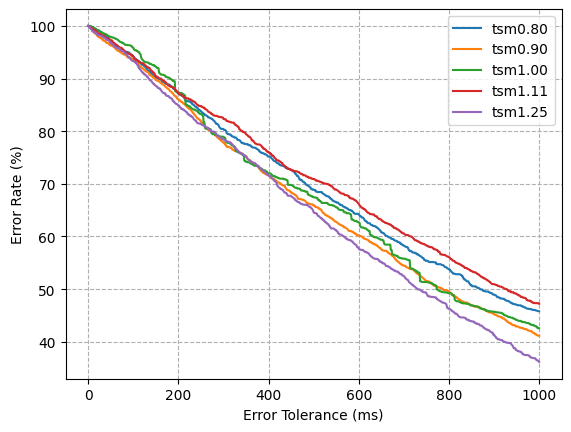

In [13]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByTSMFactor(), maxTol)

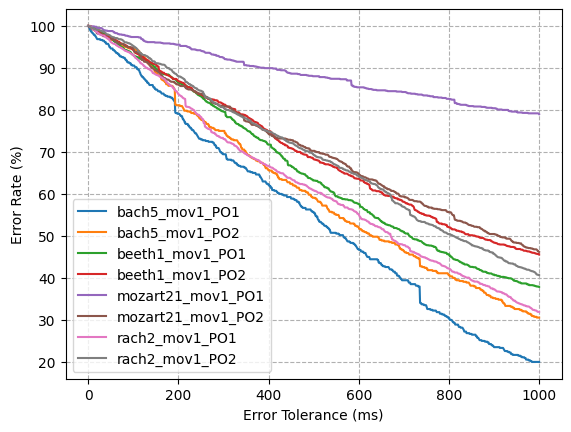

In [14]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByFullMix(), maxTol)

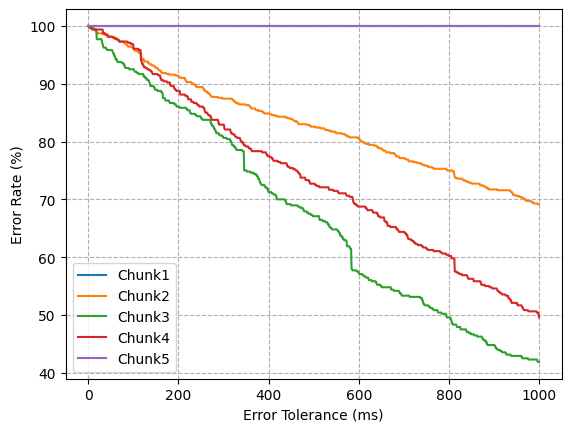

In [15]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByChunk('mozart21_mov1'), maxTol)

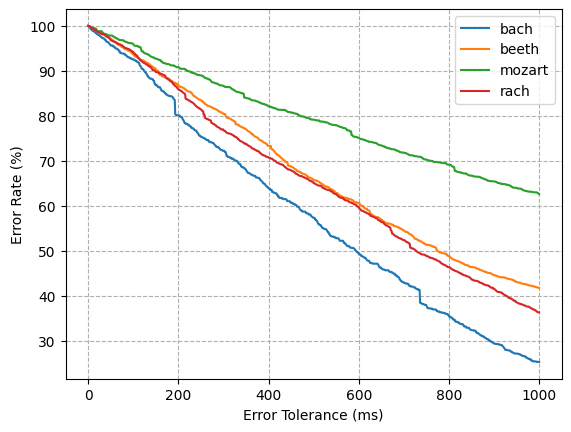

In [16]:
errRates_list, tols, numPts = plotErrorVsTolerance_separated(eval_dir, mapByComposer(), maxTol)